In [10]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV

"IMDB dataset", contains a set of 50,000 highly-polarized reviews from the Internet Movie Database.
They are split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting in 50% negative 
and 50% positive reviews.

In [7]:
X_train = pd.read_csv("./IMDB dataset/IMDB dataset/X_train.csv", header=None)
y_train = pd.read_csv("./IMDB dataset/IMDB dataset/y_train.csv", header=None)
X_test = pd.read_csv("./IMDB dataset/IMDB dataset/X_test.csv", header=None)
y_test = pd.read_csv("./IMDB dataset/IMDB dataset/y_test.csv", header=None)

X_train = np.array(X_train)
y_train = np.array(y_train).reshape((-1))
X_test = np.array(X_test)
y_test = np.array(y_test).reshape((-1))

In [8]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (25000, 1000)
y_train shape: (25000,)
X_test shape: (25000, 1000)
y_test shape: (25000,)


# Random Forest

In [19]:
# Hyperparametres to tune
nb_estimators = [50,100,200,300]
max_d = [10,20,30]

In [20]:
#Define model and find best parameter values using GridSearch
hp_tune = False
if hp_tune:
    clf_RF = RandomForestClassifier()
    parameters = {'n_estimators':nb_estimators, "max_depth":max_d}
    clf_RF = GridSearchCV(clf_RF, parameters, cv=4, return_train_score=True)
    clf_RF.fit(X_train, y_train)
    print("Optimal parameter values: {}".format(clf_RF.best_params_))
    print("Optimal validation score: {:.2f}%".format(100*clf_RF.best_score_))

Optimal parameter values: {'max_depth': 30, 'n_estimators': 300}
Optimal validation score: 82.76%


In [14]:
# Run the model with the optimal obtained parameters
optimal_c = 300
optimal_d =  30
clf_RF =  RandomForestClassifier(n_estimators =optimal_c , max_depth=optimal_d, random_state=0)

if not os.path.exists("./RandomForest.joblib"):
    clf_RF.fit(X_train, y_train)
    with open('./RandomForest.joblib', 'wb') as f:
        joblib.dump(clf_RF, f)
else:
    with open('./RandomForest.joblib', 'rb') as f:
        clf_RF = joblib.load(f)

In [15]:
# Generate label predictions and prediction probabilities
y_pred = clf_RF.predict(X_test)
y_pred_proba = clf_RF.predict_proba(X_test)

In [38]:
y_pred

array([0., 1., 1., ..., 0., 0., 0.])

In [39]:
y_pred_proba

array([[0.59380985, 0.40619015],
       [0.29492795, 0.70507205],
       [0.42007284, 0.57992716],
       ...,
       [0.72209359, 0.27790641],
       [0.77820277, 0.22179723],
       [0.63034547, 0.36965453]])

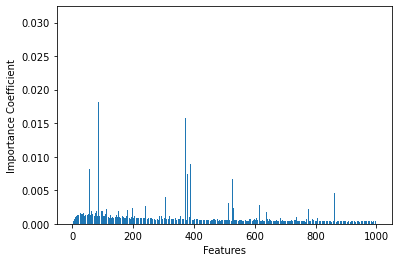

In [40]:
# Generate importance coefficients for the 1000 features
importance_RF = clf_RF.feature_importances_
plt.bar(np.arange(len(importance_RF)), importance_RF)
plt.xlabel("Features")
plt.ylabel("Importance Coefficient")
plt.show()

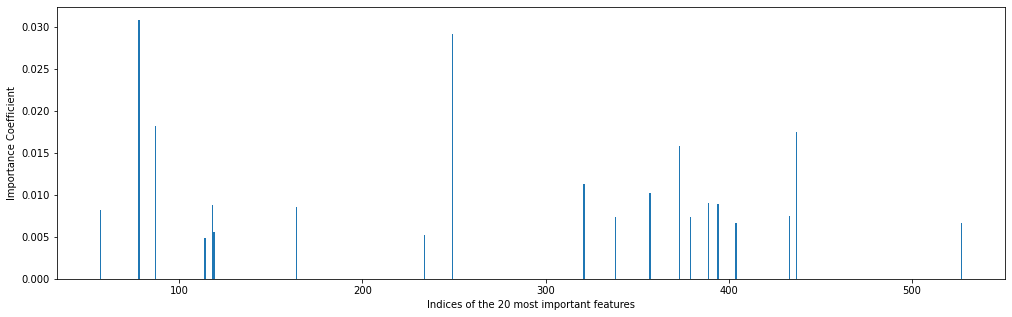

In [18]:
# Rank the feature importances and select the top k
topk_features = 20
sorted_importance_RF_idx = np.argsort(np.abs(importance_RF))[::-1][:topk_features]

top_features_RF = importance_RF[sorted_importance_RF_idx]

plt.figure(figsize=(17,5))
plt.bar(sorted_importance_RF_idx, top_features_RF)
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Importance Coefficient")
plt.show()

Text(0.5, 1.0, 'Occurences of top 20 most important features over the top 100 correctly classified positive samples')

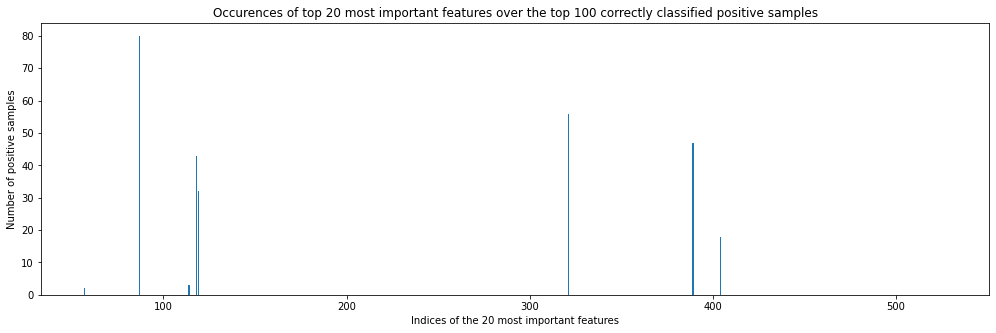

In [41]:
# Look at the correctly classified positive samples
correct_positive_proba = y_pred_proba[(y_test==1) & (y_pred == 1)][:,1]

# Select the top k test instances that have the highest prediction confidences
topk = 100
top_correct_positive_idx = np.argsort(correct_positive_proba)[::-1][:topk]

# Retrieve the corresponding data for the selected top k test instances
correct_positive_samples = X_test[(y_test==1) & (y_pred == 1)]
top_correct_positive_samples = correct_positive_samples[top_correct_positive_idx]

# Sum over the instance axis to find the occurence of the each feature over the top k selected samples
aggregated_top_correct_positive_samples = top_correct_positive_samples.sum(axis=0)

# Visualize the occurence for only the most important features
plt.figure(figsize=(17,5))
plt.bar(sorted_importance_RF_idx, aggregated_top_correct_positive_samples[sorted_importance_RF_idx])
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Number of positive samples")
plt.title("Occurences of top {} most important features over the top {} correctly classified positive samples".format(topk_features, topk))

Text(0.5, 1.0, 'Occurences of top 20 most important features over the top 100 correctly classified negative samples')

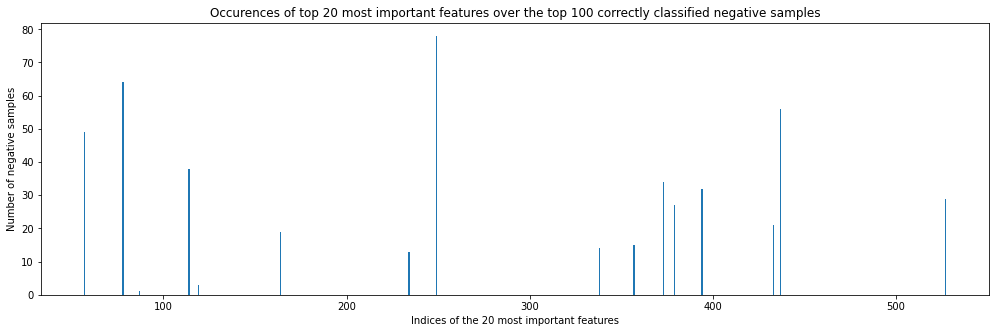

In [20]:
# Look at the correctly classified negative samples
correct_negative_proba = y_pred_proba[(y_test==0) & (y_pred == 0)][:,0]

# Select the top k test instances that have the highest prediction confidences
topk = 100
top_correct_negative_idx = np.argsort(correct_negative_proba)[::-1][:topk]

# Retrieve the corresponding data for the selected top k test instances
correct_negative_samples = X_test[(y_test==0) & (y_pred == 0)]
top_correct_negative_samples = correct_negative_samples[top_correct_negative_idx]

# Sum over the instance axis to find the occurence of the each feature over the top k selected samples
aggregated_top_correct_negative_samples = top_correct_negative_samples.sum(axis=0)

# Visualize the occurence
plt.figure(figsize=(17,5))
plt.bar(sorted_importance_RF_idx, aggregated_top_correct_negative_samples[sorted_importance_RF_idx])
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Number of negative samples")
plt.title("Occurences of top {} most important features over the top {} correctly classified negative samples".format(topk_features, topk))

Text(0.5, 1.0, 'Positive occurence - Negative occurence')

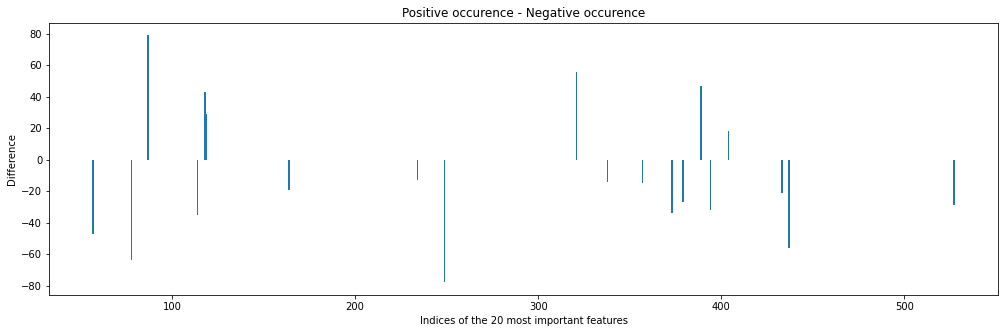

In [21]:
#Compute the difference between the aggregated features of the positive and negative samples
difference = aggregated_top_correct_positive_samples[sorted_importance_RF_idx]-aggregated_top_correct_negative_samples[sorted_importance_RF_idx]
plt.figure(figsize=(17,5))
plt.bar(sorted_importance_RF_idx, difference)
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Difference")
plt.title("Positive occurence - Negative occurence")

In [22]:
top_positive_features = sorted_importance_RF_idx[difference>0]
top_negative_features = sorted_importance_RF_idx[difference<0]

In [23]:
top_positive_features

array([ 87, 321, 389, 118, 404, 119], dtype=int64)

In [24]:
top_negative_features

array([ 78, 249, 437, 373, 357, 394, 164,  57, 433, 338, 379, 527, 234,
       114], dtype=int64)

Text(0.5, 1.0, '0 classified as 1')

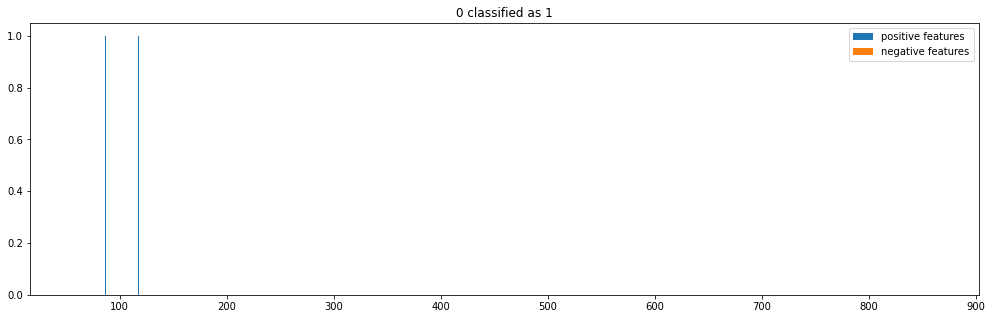

In [59]:
# Study the feature content of a selected test sample
ytrue = 0
ypred = 1
idx = 0

proba = y_pred_proba[(y_test==ytrue) & (y_pred == ypred)][:,ypred]

top_idx = np.argsort(proba)[::-1][idx]

samples = X_test[(y_test==ytrue) & (y_pred == ypred)]
selected_sample = samples[top_idx]

plt.figure(figsize=(17,5))
plt.bar(top_positive_features, selected_sample[top_positive_features], label = "positive features")
plt.bar(top_negative_features, selected_sample[top_negative_features], label = "negative features")
plt.legend()
plt.title("{} classified as {}".format(ytrue, ypred))

## Gradient Boosting Regression Trees

In [60]:
# Run the model with the optimal obtained parameters
optimal_n = 400
optimal_d =  5
clf_GBR =  GradientBoostingClassifier(n_estimators =optimal_n , max_depth=optimal_d, random_state=0)

if not os.path.exists("./GradBoostTrees.joblib"):
    clf_GBR.fit(X_train, y_train)
    with open('./GradBoostTrees.joblib', 'wb') as f:
        joblib.dump(clf_GBR, f)
else:
    with open('./RandomForest.joblib', 'rb') as f:
        clf_GBR = joblib.load(f)

In [61]:
# Generate label predictions and prediction probabilities
y_pred = clf_GBR.predict(X_test)
y_pred_proba = clf_GBR.predict_proba(X_test)

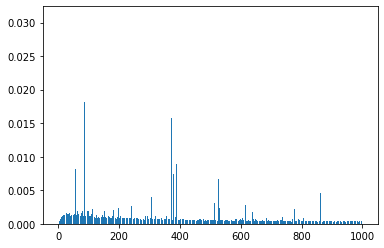

In [62]:
# Generate importance coefficients for the 1000 features
importance_GBR = clf_GBR.feature_importances_
plt.bar(np.arange(len(importance_GBR)), importance_GBR)
plt.show()

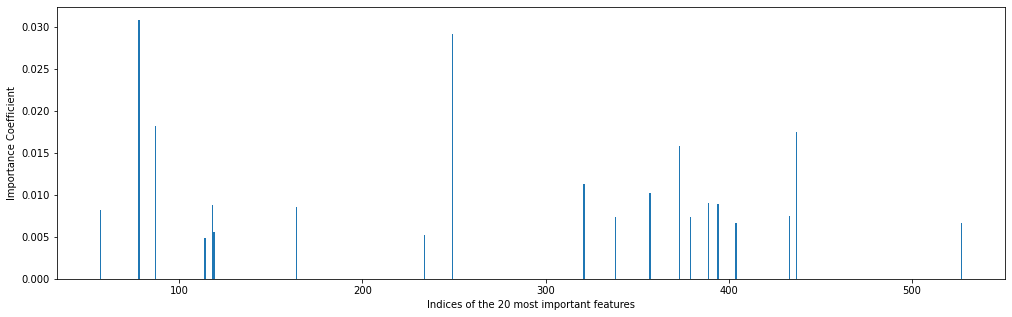

In [63]:
# Rank the feature importances and select the top k
topk_features = 20
sorted_importance_GBR_idx = np.argsort(np.abs(importance_GBR))[::-1][:topk_features]

top_features_GBR = importance_GBR[sorted_importance_GBR_idx]

plt.figure(figsize=(17,5))
plt.bar(sorted_importance_GBR_idx, top_features_GBR)
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Importance Coefficient")
plt.show()

Text(0.5, 1.0, 'Occurences of top 20 most important features in the top 100 correctly classified positive samples')

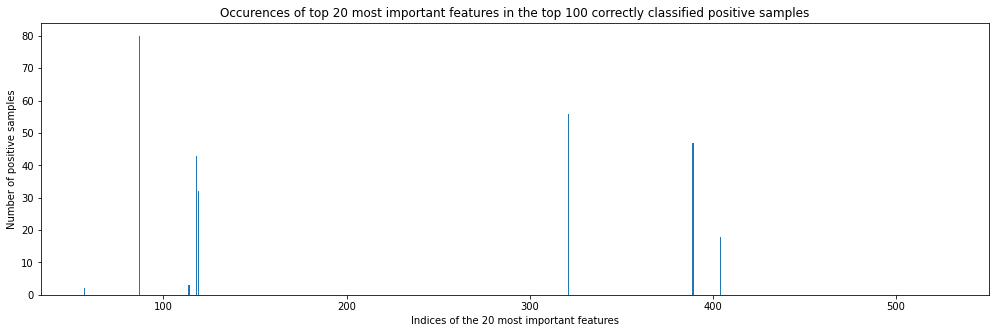

In [64]:
# Look at the correctly classified positive samples
correct_positive_proba = y_pred_proba[(y_test==1) & (y_pred == 1)][:,1]

# Select the top k test instances that have the highest prediction confidences
topk = 100
top_correct_positive_idx = np.argsort(correct_positive_proba)[::-1][:topk]

# Retrieve the corresponding data for the selected top k test instances
correct_positive_samples = X_test[(y_test==1) & (y_pred == 1)]
top_correct_positive_samples = correct_positive_samples[top_correct_positive_idx]

# Sum over the instance axis to find the occurence of the each feature over the top k selected samples
aggregated_top_correct_positive_samples = top_correct_positive_samples.sum(axis=0)

# Visualize the occurence for only the most important features
plt.figure(figsize=(17,5))
plt.bar(sorted_importance_GBR_idx, aggregated_top_correct_positive_samples[sorted_importance_GBR_idx])
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Number of positive samples")
plt.title("Occurences of top {} most important features in the top {} correctly classified positive samples".format(topk_features, topk))

Text(0.5, 1.0, 'Occurences of top 20 most important features in the top 100 correctly classified negative samples')

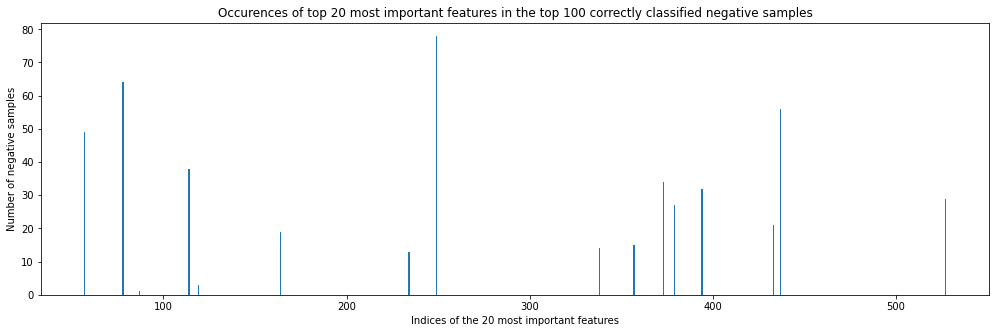

In [65]:
# Look at the correctly classified negative samples
correct_negative_proba = y_pred_proba[(y_test==0) & (y_pred == 0)][:,0]

# Select the top k test instances that have the highest prediction confidences
topk = 100
top_correct_negative_idx = np.argsort(correct_negative_proba)[::-1][:topk]

# Retrieve the corresponding data for the selected top k test instances
correct_negative_samples = X_test[(y_test==0) & (y_pred == 0)]
top_correct_negative_samples = correct_negative_samples[top_correct_negative_idx]

# Sum over the instance axis to find the occurence of the each feature over the top k selected samples
aggregated_top_correct_negative_samples = top_correct_negative_samples.sum(axis=0)

# Visualize the occurence for only the most important features
plt.figure(figsize=(17,5))
plt.bar(sorted_importance_GBR_idx, aggregated_top_correct_negative_samples[sorted_importance_GBR_idx])
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Number of negative samples")
plt.title("Occurences of top {} most important features in the top {} correctly classified negative samples".format(topk_features, topk))

Text(0.5, 1.0, 'Positive occurence - Negative occurence')

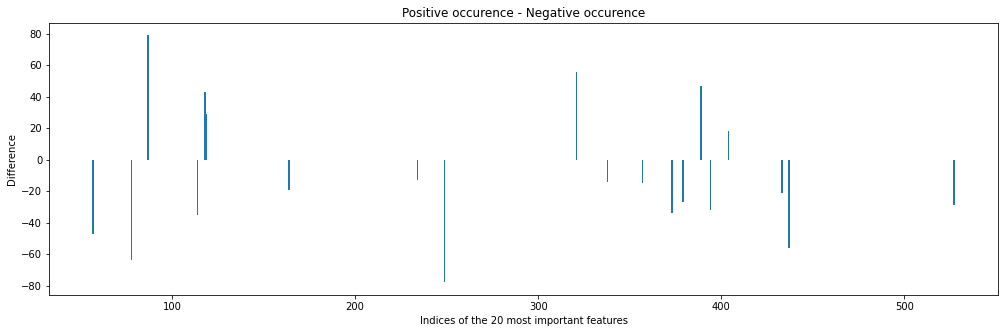

In [66]:
#Compute the difference between the aggregated features of the positive and negative samples

difference = aggregated_top_correct_positive_samples[sorted_importance_GBR_idx]-aggregated_top_correct_negative_samples[sorted_importance_GBR_idx]
plt.figure(figsize=(17,5))
plt.bar(sorted_importance_GBR_idx, difference)
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Difference")
plt.title("Positive occurence - Negative occurence")

In [67]:
top_positive_features = sorted_importance_GBR_idx[difference>0]
top_negative_features = sorted_importance_GBR_idx[difference<0]

Text(0.5, 1.0, '0 classified as 1')

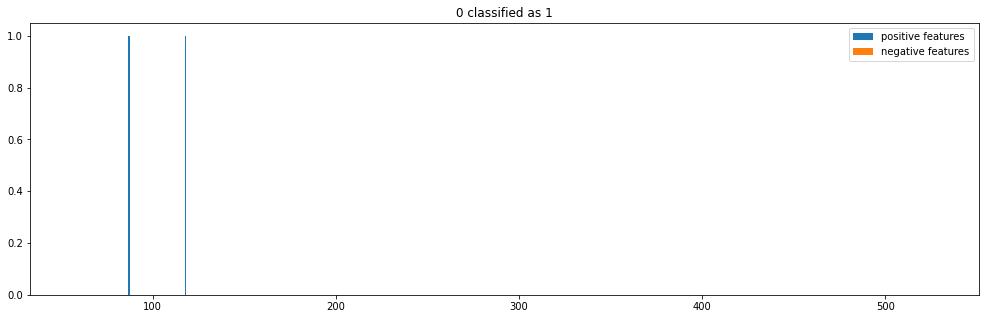

In [72]:
# Study the feature content of a selected test sample
ytrue = 0
ypred = 1
idx = 0

proba = y_pred_proba[(y_test==ytrue) & (y_pred == ypred)][:,ypred]

top_idx = np.argsort(proba)[::-1][idx]

samples = X_test[(y_test==ytrue) & (y_pred == ypred)]
selected_sample = samples[top_idx]

plt.figure(figsize=(17,5))
plt.bar(top_positive_features, selected_sample[top_positive_features], label = "positive features")
plt.bar(top_negative_features, selected_sample[top_negative_features], label = "negative features")
plt.legend()
plt.title("{} classified as {}".format(ytrue, ypred))

# Multinomial Naive Bayes with additive smoothing

In [73]:
alpha = [1.0,2.0,3.0,5.0]

clf_NB = MultinomialNB()
parameters = {'alpha':alpha}
clf_NB = GridSearchCV(clf_NB, parameters, cv=4, return_train_score=True)
clf_NB.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=MultinomialNB(),
             param_grid={'alpha': [1.0, 2.0, 3.0, 5.0]},
             return_train_score=True)

In [76]:
clf_NB.best_params_

{'alpha': 1.0}

In [77]:
clf_NB.best_score_

0.83232

In [78]:
# Train model with optimal parameter values
clf_NB = MultinomialNB(alpha=1.0)
clf_NB.fit(X_train, y_train)
y_pred = clf_NB.predict(X_test)
y_pred_proba = clf_NB.predict_proba(X_test)

In [98]:
# Select the top k most important features
topk_features = 20

diff = clf_NB.feature_log_prob_[1, :] - clf_NB.feature_log_prob_[0, :]

top_positive_features = np.argsort(diff)[::-1][:topk_features//2]
top_negative_features = np.argsort(diff)[::-1][-topk_features//2:]

In [80]:
top_positive_features

array([897, 389, 321, 777, 480, 404, 976, 514, 950, 530], dtype=int64)

In [81]:
top_negative_features

array([394, 913, 947, 527, 595, 835, 862, 373, 249, 437], dtype=int64)

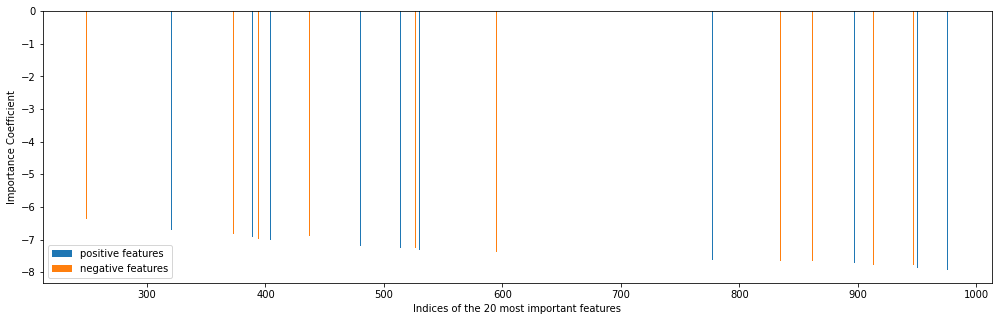

In [82]:
plt.figure(figsize=(17,5))
plt.bar(top_positive_features, clf_NB.feature_log_prob_[1, :][top_positive_features], label = "positive features")
plt.bar(top_negative_features, clf_NB.feature_log_prob_[0, :][top_negative_features], label = "negative features")
plt.xlabel("Indices of the {} most important features".format(topk_features))
plt.ylabel("Importance Coefficient")
plt.legend()

Text(0.5, 1.0, '1 classified as 1')

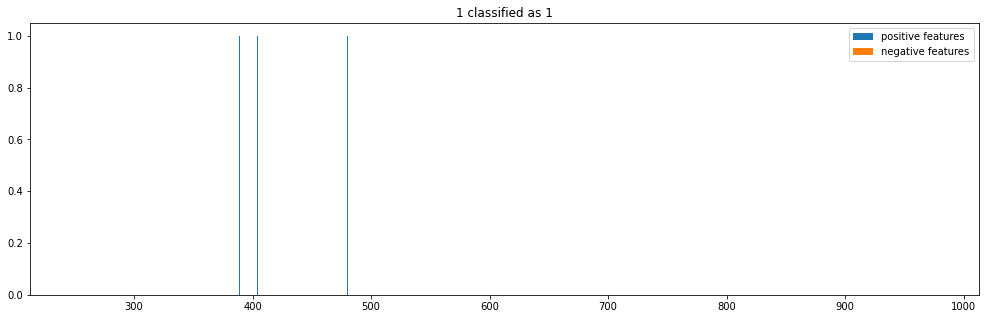

In [111]:
# Study the feature content of a selected test sample
ytrue = 0
ypred = 0
idx = 1

proba = y_pred_proba[(y_test==ytrue) & (y_pred == ypred)][:,ypred]

top_idx = np.argsort(proba)[::-1][idx]

samples = X_test[(y_test==ytrue) & (y_pred == ypred)]
selected_sample = samples[top_idx]

plt.figure(figsize=(17,5))
plt.bar(top_positive_features, selected_sample[top_positive_features], label = "positive features")
plt.bar(top_negative_features, selected_sample[top_negative_features], label = "negative features")
plt.legend()
plt.title("{} classified as {}".format(ytrue, ypred))